In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import datetime
%matplotlib inline

In [2]:
aqi_url = "https://raw.githubusercontent.com/DONI-13/Lahore-Air-Quality-Index-Predictor/main/lahore_aqi.csv"
aqi_df = pd.read_csv(aqi_url, parse_dates=['date'])

In [3]:
aqi_df.head()

,date,pm25
0,2025-01-01,355
1,2025-01-02,389
2,2025-01-03,530
3,2025-01-04,345
4,2025-01-05,304


In [4]:
#changing pm25 heading to AQI
aqi_df.columns = ['date', 'AQI']


In [5]:
# Convert the date column to proper datetime format and order.
aqi_df['date'] = pd.to_datetime(aqi_df['date'])
aqi_df = aqi_df.sort_values('date', ascending=False).reset_index(drop=True)
aqi_df.head()

,date,AQI
0,2025-02-18,272
1,2025-02-17,203
2,2025-02-16,224
3,2025-02-15,173
4,2025-02-14,189


In [6]:
from datetime import datetime

def get_weather_data(start_date, end_date):
    url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude=31.5497&longitude=74.3436"
        f"&start_date={start_date}&end_date={end_date}"
        f"&daily=temperature_2m_mean,windspeed_10m_mean,rain_sum"
        f"&timezone=Asia%2FKarachi"
    )
    
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")
    
    data = response.json()
    

    weather_df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'temp': data['daily']['temperature_2m_mean'],
        'wind_speed': data['daily']['windspeed_10m_mean'],
        'rain_sum': data['daily']['rain_sum']
    })
    
    return weather_df




In [7]:
# creating a weather_df for aqi_df dates
start = aqi_df['date'].min().strftime('%Y-%m-%d')
end = aqi_df['date'].max().strftime('%Y-%m-%d')
weather_df = get_weather_data(start, end)
weather_df.head()

,date,temp,wind_speed,rain_sum
0,2019-05-09,33.9,10.2,0.0
1,2019-05-10,32.9,8.1,0.0
2,2019-05-11,29.5,9.8,0.6
3,2019-05-12,30.7,8.6,0.0
4,2019-05-13,29.7,8.9,1.9


In [8]:
#merging weather_df and aqi_df
merged_df = pd.merge(aqi_df, weather_df, on='date', how='inner')
merged_df.head()

,date,AQI,temp,wind_speed,rain_sum
0,2025-02-18,272,18.5,5.2,0.0
1,2025-02-17,203,18.3,4.9,0.0
2,2025-02-16,224,17.8,4.7,0.0
3,2025-02-15,173,18.3,4.0,1.4
4,2025-02-14,189,17.0,4.4,0.0


In [9]:
# Step 4: Set Seaborn style
sns.set(style='whitegrid', palette='muted')

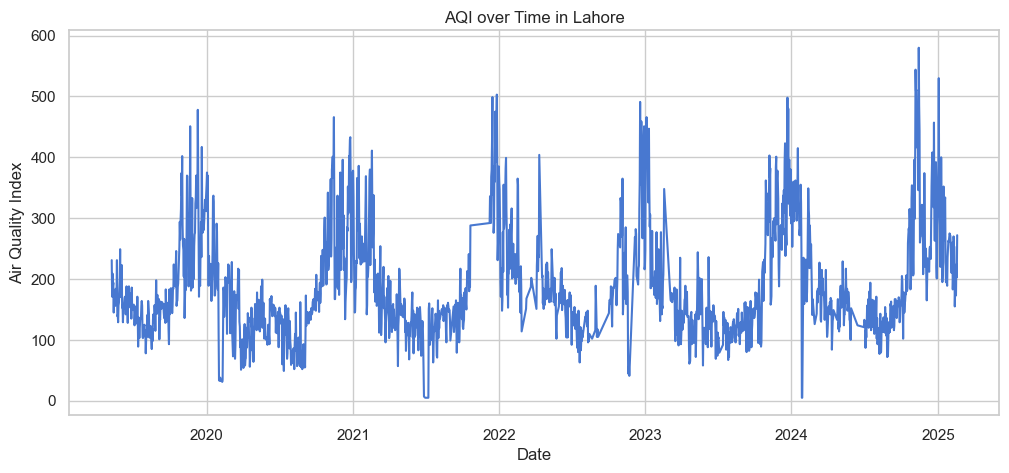

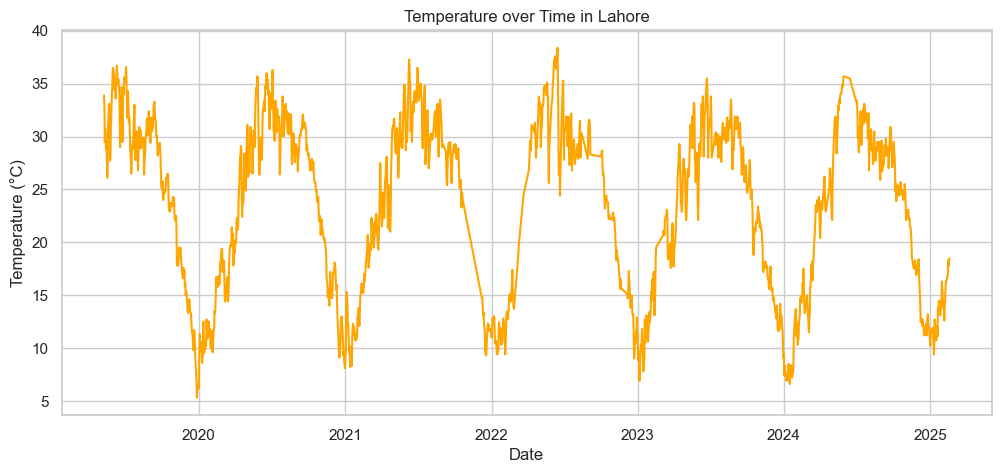

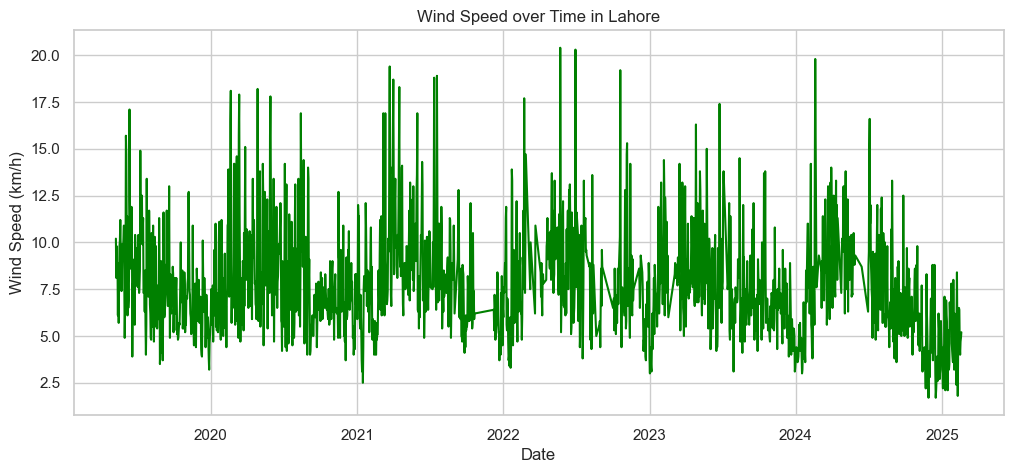

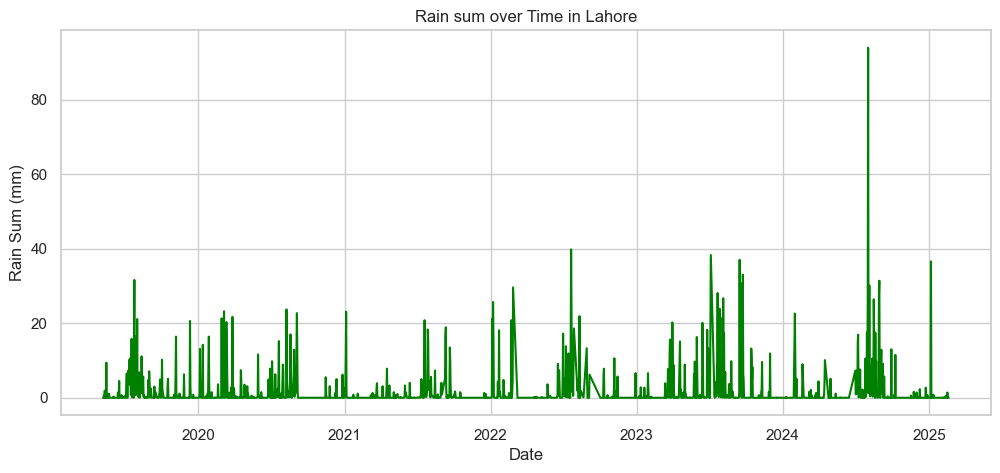

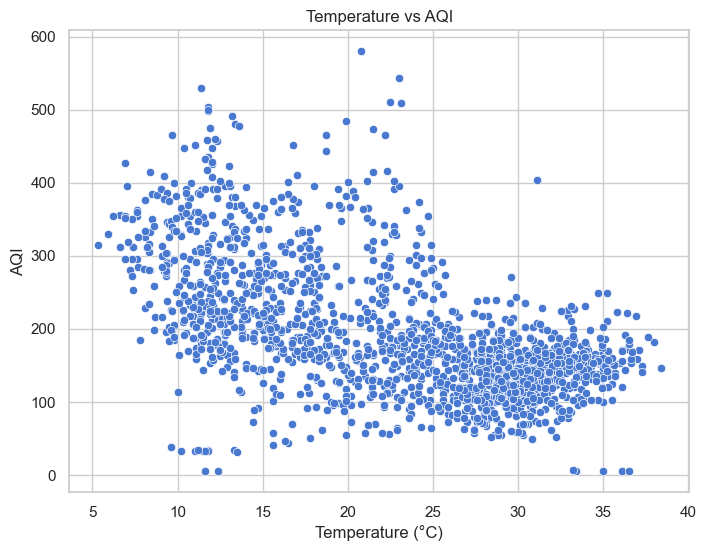

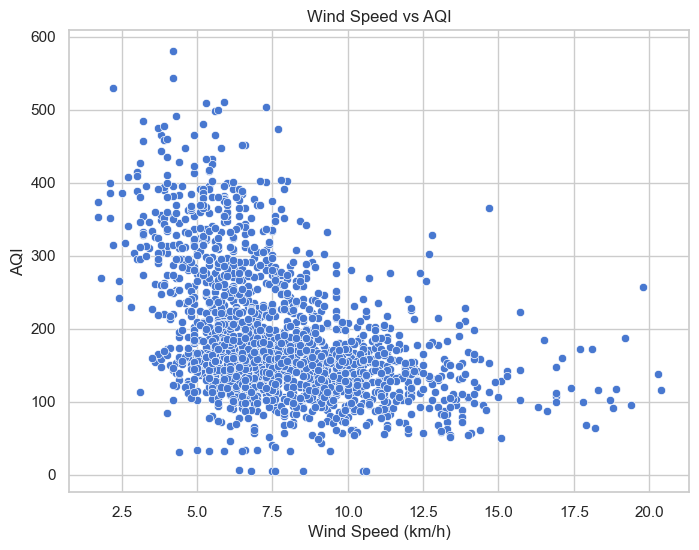

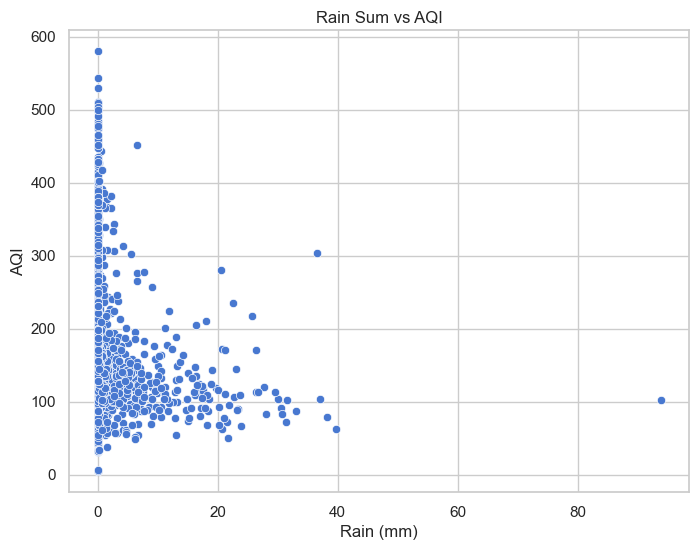

In [10]:
# AQI vs Date
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='AQI', data=merged_df)
plt.title('AQI over Time in Lahore')
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.show()

# Temperature vs Date
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='temp', data=merged_df, color='orange')
plt.title('Temperature over Time in Lahore')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

# Wind Speed vs Date
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='wind_speed', data=merged_df, color='green')
plt.title('Wind Speed over Time in Lahore')
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.show()

# rain_sum vs Date
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='rain_sum', data=merged_df, color='green')
plt.title('Rain sum over Time in Lahore')
plt.xlabel('Date')
plt.ylabel('Rain Sum (mm)')
plt.show()

# Temperature vs AQI
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temp', y='AQI', data=merged_df)
plt.title('Temperature vs AQI')
plt.xlabel('Temperature (°C)')
plt.ylabel('AQI')
plt.show()

# Wind Speed vs AQI
plt.figure(figsize=(8, 6))
sns.scatterplot(x='wind_speed', y='AQI', data=merged_df)
plt.title('Wind Speed vs AQI')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('AQI')
plt.show()

# rain sum vs AQI
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rain_sum', y='AQI', data=merged_df)
plt.title('Rain Sum vs AQI')
plt.xlabel('Rain (mm)')
plt.ylabel('AQI')
plt.show()



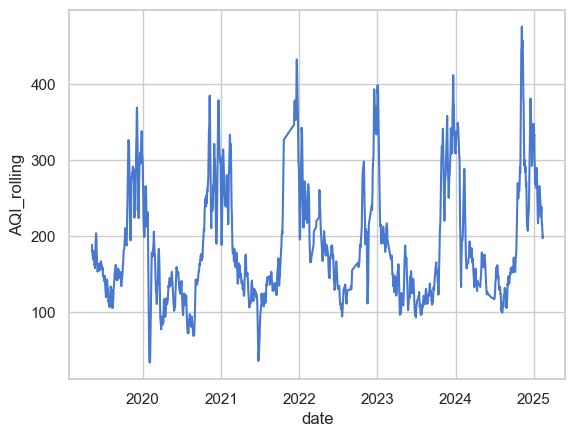

In [11]:
#Rolling Average Plot: Smoothing noisy data to reveal long-term trends.
merged_df['AQI_rolling'] = merged_df['AQI'].rolling(window=7).mean()
sns.lineplot(x='date', y='AQI_rolling', data=merged_df)
plt.show()

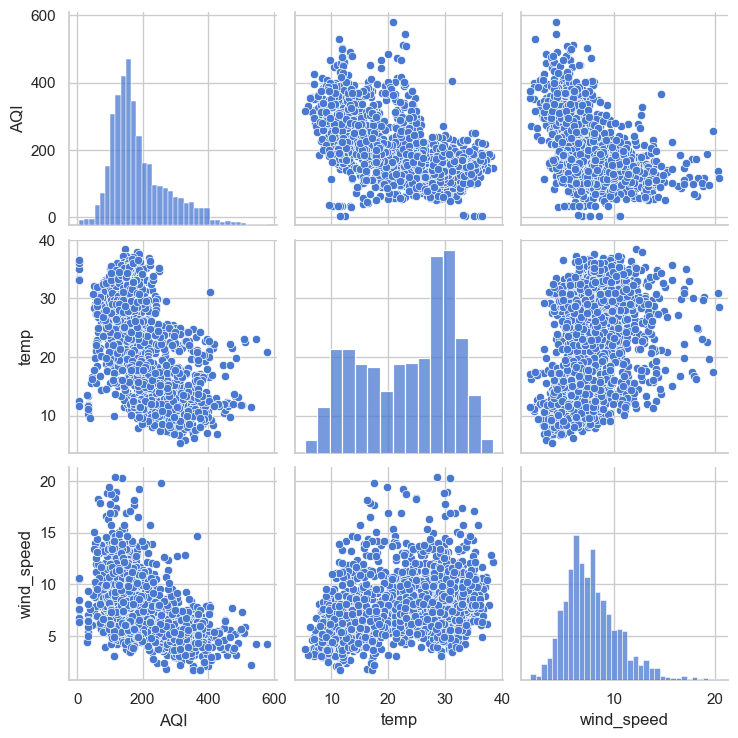

In [12]:
#Pairplot (Correlation Matrix Style):Getting a holistic view of how variables relate.
sns.pairplot(merged_df[['AQI', 'temp', 'wind_speed']])
plt.show()

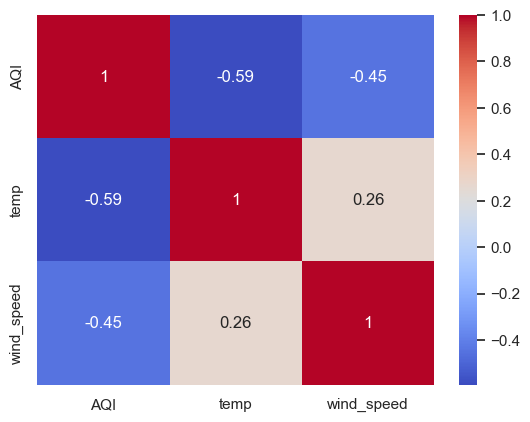

In [13]:
#Heatmap (Correlation Matrix): Quickly identifying correlation strength between variables.
corr = merged_df[['AQI', 'temp', 'wind_speed']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Drop rows with missing values
df_clean = merged_df.dropna()

# Extract month and day of week from date
# Pollution patterns often follow seasonal and weekly cycles.
df_clean['month'] = df_clean['date'].dt.month
df_clean['day_of_week'] = df_clean['date'].dt.dayofweek

# Include these in the features
X = df_clean[['temp', 'wind_speed', 'rain_sum', 'month', 'day_of_week']]
y = df_clean['AQI']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\Doni\AppData\Local\Temp\ipykernel_8012\1548090710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['month'] = df_clean['date'].dt.month
C:\Users\Doni\AppData\Local\Temp\ipykernel_8012\1548090710.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['day_of_week'] = df_clean['date'].dt.dayofweek


In [15]:
# Create and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred = lr_model.predict(X_test)


In [16]:
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")


Mean Absolute Error: 47.39
Mean Squared Error: 3769.95
R-squared Score: 0.48


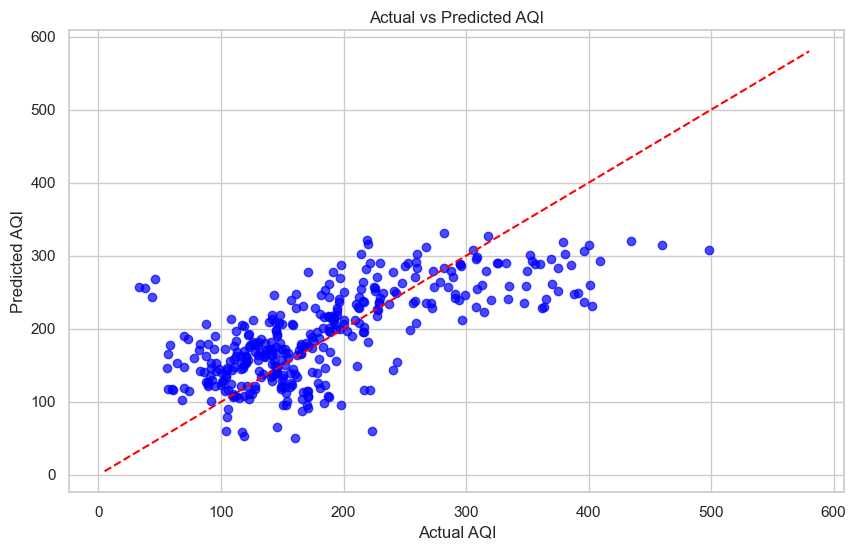

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.grid(True)
plt.show()


In [18]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest R²:", r2_score(y_test, rf_pred))


Random Forest R²: 0.6139536266873


In [19]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

print("XGBoost R²:", r2_score(y_test, xgb_pred))


XGBoost R²: 0.5753473043441772


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best R²:", grid.best_score_)


Best Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best R²: 0.6500826922646404


In [21]:
print("XGBoost R²:", r2_score(y_test, xgb_pred))

XGBoost R²: 0.5753473043441772


In [22]:
# Assuming 'new_weather_data' is a DataFrame with similar features: temp, wind_speed, rain_sum, month, and day_of_week
new_weather_data = pd.DataFrame({
    'temp': [25, 32],  # Example temperature data
    'wind_speed': [8, 7],  # Example wind speed data
    'rain_sum': [0, 0],  # Example rain data
    'month': [4, 4],  # Example months
    'day_of_week': [2, 1]  # Example weekdays (0 = Monday, 1 = Tuesday, etc.)
})

# Predict AQI using the trained XGBoost model
predicted_aqi = xgb.predict(new_weather_data)

print("Predicted AQI values:", predicted_aqi)


Predicted AQI values: [137.58514 212.74782]
